<br><p style="text-align: center; font-size:50px; color:rgb(255,0,51)">Happy Adventure</p><br>

## Preguntas a responder
Respondo a las preguntas del business case en esta sección y más adelante desarrollo el modelo.

### 1. ¿Qué modelo o modelos serían adecuados para resolver este objetivo?

En primer lugar **regresión logística** debido a que la variable objetivo es binaria y por la facilidad de interpretar los resultados y determinar las variables relevantes.

Para intentar mejorar la precisión se puede hacer un **random forest, xgboost, una red neuronal, etc**. en el caso de la red neuronal seguramente no mejore la precisión significativamente para compensar la perdida de interpretabilidad.


### 2. ¿Qué proceso deberíamos seguir para poder desarrollar el modelo que necesitamos?
#### ¿Qué debemos tener en cuenta en cada fase del proceso?

*1. Definición de un objetivo*

Hay que tener claro lo que queremos hacer, en este caso predecir la intención de un cliente de volver al parque de atracciones.

*2. Validación de los datos*

Revisar duplicados, valores atípicos, correlaciones, en caso de haber datos oficiales para comparar comprobar que los datos que nos han pasado cuadran con los datos oficiales

*3. Hacer un análisis univariable.*

Necesario para ver el impacto que tiene cada variable individualmente en la variable objetivo y hacernos una idea inicial de cada variable o encontrar posibles problemas.

*4. Preparación de la base de datos para modelización.*

Juntar toda la información disponible, crear agrupaciones, crear nuevas variables a partir de otras, imputar valores atípicos.

*5. Entrenamiento de los modelos.*

Separar los datos en train y test.
Sobre la base de datos de train probar distintos modelos, seleccionar las variables que entran o ajustar sus parámetros

*6. Validación del modelo.*

Sobre el test ver la capacidad predictiva del modelo y que tan bien se ajustan las predicciones a la realidad.
Seleccionar el modelo definitivo.

*7. Implementación del modelo.*

Llevar el modelo a producción.

*La creación del modelo es un proceso iterativo, en cualquier momento se puede volver atrás para hacer cambios.*

### 3. Desarrolla al menos uno de los modelos que consideres adecuados para este caso.
#### ¿Qué problemas has encontrado en cada fase del proceso?
#### ¿Qué decisiones has tomado para evitar/solucionar cada uno de los problemas encontrados? Justifica tu respuesta.

*Validación de los datos:*
- Duplicados en la tabla de clientes y puntos de compra.

    Se ha comprobado que las observaciones duplicadas lo son en todas las variables y por tanto se han eliminado.<br><br>
  
- La edad de los clientes con valores perdidos.

    En este caso imputamos los valores perdidos puesto que representaban el 20% de la BBDD y no tenemos suficientes observaciones como para permitirnos eliminarlas directamente. Además estos valores nulos pueden estar asociados a una característica de un cliente. Otros clientes tienen la edad con decimales pero hemos supuesto que estan bien (calculado a partir del mes y día de nacimiento) y no es un error de entrada de datos.<br><br>
    
- Valores de NA en punto de compra

    Decidimos dejarlos por ser solamente 2 observaciones que tienen el resto de valores normales.
    Esto implica que hay una categoría extra para cuando el punto de compra no este informado.<br><br>
    
- Correlación completa del producto B y C.

    En este caso descartamos directamente el producto C para los modelos.


*Análisis univariable:*

- Me parece curioso que a pesar de que el 65% de los clientes son hombres, solamente el 19% tiene intención de volver, mientras que el 74,2% de las mujeres tienen intención de volver.<br><br>

- Hay clientes muy pequeños contestando la encuesta (<10 años) y tiene sentido en cuanto a que casi todos van acompañados de familiares o amigos, sin embargo, puede ser un problema mezclar las opiniones de adultos con los niños. (Un niño puede tener intención de volver pero el hecho de volver depende del padre). Hay diferencias significativa entre hombres mayores y menores de 18 años (40% vs 20% de intención de volver aproximadamente).

*Entrenamiento:*

-  Es complicado determinar los mejores parámetros en el random forest por ser una base de datos pequeña y la aleatoriedad del algoritmo del random forest.

### 4. Desde Happy Adventure no estamos seguros la información de la que disponemos es la más adecuada para conseguir nuestros objetivos.
#### ¿Es adecuada la información de la que disponemos? ¿Deberíamos cambiar o añadir algún dato? – Justifica tu respuesta
#### Con los cambios que has planteados, ¿Qué deberíamos tener en cuenta en los modelos? ¿Deberíamos cambiar de modelo?

Si bien los modelos obtenidos son bastante buenos, hay más variables que se podrían recoger de cada cliente como su ubicación, ingresos, precio que pago por la entrada o descuentos.

Por otro lado se habla de que en los últimos años los clientes no repiten su visita, sin embargo, no tenemos información temporal de los clientes, p. ej. de cuando han visitado el parque o cuántas veces lo han hecho en el último año. 

En este caso se podría plantear hacer un modelo de serie temporal o enfocar el modelo de forma distinta generando una nueva variable objetivo a partir de información temporal y no de la encuesta.
El objetivo cambiaría a estimar la probabilidad real de que un cliente vuelva y no su intención.

p. ej. Si tenemos información temporal de 2018 a 2021 con información de todas las visitas de los clientes podemos crear la variable 'vuelve_proximo_anio' (para los clientes de 2018 se asigna 1 si el cliente ha visitado el parque en 2019 y 0 en caso contrario, y así para todos los años)


### 5. Imagina que la empresa precisa productivizar este algoritmo en Real Time para obtener los resultados en tiempo real; ¿Cómo lo harías y cuáles pasos llevarías a cabo?

Mejor os lo enseño: **www.test_artiel.com**
<br><br>

# Desarrollo del modelo

In [697]:
# Importación de paquetes
import os
import pandas as pd
import numpy as np
import seaborn as sn
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm 
import matplotlib.pyplot as plt

In [698]:
# Cambiamos nuestro directorio de trabajo
os.chdir('D:\Clientes\Artiel\99. Artiel\Business Case_HappyAdventure')

In [699]:
# Lectura de datos
clientes = pd.read_excel('Detalle_Clientes.xlsx')
consumo = pd.read_excel('Consumo_Parque.xlsx')
encuestas = pd.read_excel('Encuestas_parque.xlsx')
punto_compra = pd.read_excel('Punto_Compra.xlsx')

## Validación de datos
### Tabla de CLIENTES

In [700]:
print(clientes.head(), "\n")

# Comprobamos duplicados
print("Total observaciones:",clientes['ClientId'].shape[0])
print("ID's de cliente únicos:",clientes['ClientId'].unique().shape[0])


   ClientId                                             Nombre    Sexo  Edad
0         1                            Braund, Mr. Owen Harris    male  22.0
1         2  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0
2         3                             Heikkinen, Miss. Laina  female  26.0
3         4       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0
4         5                           Allen, Mr. William Henry    male  35.0 

Total observaciones: 987
ID's de cliente únicos: 891


Tenemos unos 100 duplicados de ID de cliente en esta tabla.

In [701]:
# Nos quitamos las observaciones duplicadas en todas las variables
clientes = clientes.loc[~clientes.duplicated(), ]
print("Dimensión de tabla clientes: ", clientes.shape)

Dimensión de tabla clientes:  (891, 4)


Al quitarnos los duplicados de todas las variables nos quedamos con las mismas observaciones que el número de ID's únicos, con lo cual podemos quitarnos los duplicados tranquilamente ya que nos da igual con que observación de las duplicadas nos quedamos.

In [702]:
# Por si acaso, también compruebo si hay algun cliente con el mismo nombre
print("Nombres únicos:", clientes["Nombre"].unique().shape[0])
print("No hay ningún nombre duplicado")

Nombres únicos: 891
No hay ningún nombre duplicado


In [703]:
# Distribución del sexo.
clientes['Sexo'].value_counts()

male      577
female    314
Name: Sexo, dtype: int64

El 65% de los clientes son hombres.
Supondremos que es debido al perfil de clientes del parque y no a que se este mal informando el campo.

<AxesSubplot:>

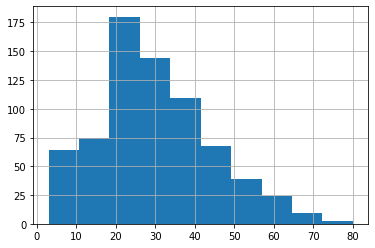

In [704]:
# Histograma de edad
clientes["Edad"].hist()

Un 20% de los clientes no tiene la edad informada.<br>
Algunas edades tienen decimales pero puede deberse a que hayan dado información de mes y día y se haya hecho un cálculo y no a un error de entrada de datos. Habría que ver a que se debe esto.

In [705]:
clientes.groupby('Sexo').agg({'Edad' : ['mean']}).round(1)

,Edad
,mean
Sexo,
female,28.1
male,30.8


La edad media de las mujeres es de 28 años y de los hombres 31 años.<br>

Quizás sería relevante diferenciar entre tipo de clientes por edad, no se puede comparar la respuesta de un niño de 5 años con la de alguién de 30.

### Tabla de CONSUMO

In [706]:
print(consumo.head(), "\n")

# Comprobamos duplicados
print("Total observaciones:",consumo['ClientId'].shape[0])
print("ID's de cliente únicos:",consumo['ClientId'].unique().shape[0])

   ClientId  Producto_A  Producto_B  Producto_C
0         1    0.824350    1.983631    4.442019
1         2   44.359555    8.311497   18.612248
2         3    4.828502    0.955905    2.140593
3         4   33.101448    6.173654   13.824897
4         5    6.930369    0.345636    0.773995 

Total observaciones: 891
ID's de cliente únicos: 891


<AxesSubplot:>

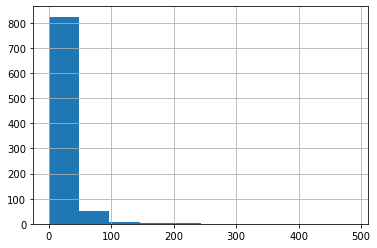

In [707]:
consumo['Producto_A'].hist()

<AxesSubplot:>

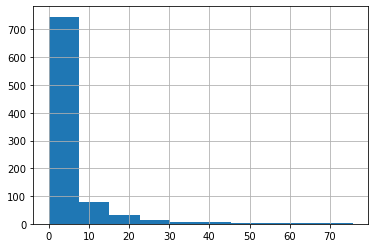

In [708]:
consumo['Producto_B'].hist()

Podemos ver con los histogramas de consumo de productos que siguen una distribución exponencial, puede ser útil una transformación logarítmica para el modelo de regresión logística. No muestro el histograma del Producto_C puesto que es redundante como se verá más adelante en las correlaciones.

In [709]:
# Vemos la media del consumo por producto
consumo.agg({'Producto_A' : ['mean'],'Producto_B' : ['mean'], 'Producto_C' : ['mean']}).round(1)

,Producto_A,Producto_B,Producto_C
mean,16.1,5.0,11.2


La gente ha consumido más del producto A, luego C y por último B.

Hago los histogramas de las variables de producto con la transformación logarítmica y vemos que ya tienen una pinta más normal:

<AxesSubplot:>

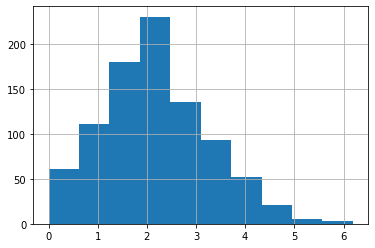

In [710]:
np.log(consumo['Producto_A']+1).hist() # Le sumo 1 a la variable para evitar problemas con los 0

<AxesSubplot:>

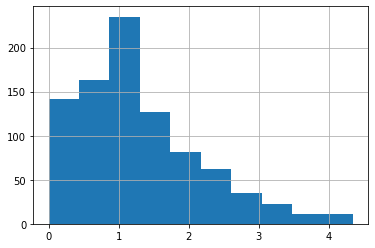

In [711]:
np.log(consumo['Producto_B']+1).hist() # Le sumo 1 a la variable para evitar problemas con los 0

## Tabla de ENCUESTAS

In [712]:
print(encuestas.head(), "\n")

# Comprobamos duplicados
print("Total observaciones:",encuestas['ClientId'].shape[0])
print("ID's de cliente únicos:",encuestas['ClientId'].unique().shape[0])

   Unnamed: 0  ClientId  Intencion_volver  Segmento_cliente  \
0           0         1                 0                 3   
1           1         2                 1                 1   
2           2         3                 1                 3   
3           3         4                 1                 1   
4           4         5                 0                 3   

   Acompaniado_amigos  Acompaniado_familia  
0                   1                    0  
1                   1                    0  
2                   0                    0  
3                   1                    0  
4                   0                    0   

Total observaciones: 891
ID's de cliente únicos: 891


In [713]:
# Me quito la variable Unnamed que tiene pinta de ser el index del dataframe que se quedo guardado
del encuestas['Unnamed: 0']
encuestas.head()

,ClientId,Intencion_volver,Segmento_cliente,Acompaniado_amigos,Acompaniado_familia
0,1,0,3,1,0
1,2,1,1,1,0
2,3,1,3,0,0
3,4,1,1,1,0
4,5,0,3,0,0


In [714]:
encuestas.agg(['sum', 'mean']).round(2)

,ClientId,Intencion_volver,Segmento_cliente,Acompaniado_amigos,Acompaniado_familia
sum,397386.0,342.00,2057.00,466.00,340.00
mean,446.0,0.38,2.31,0.52,0.38


En esta tabla ya podemos ver que el 38% de los clientes tiene intención de volver al parque de atracciones.
Además el 52% vienen acompañados por amigos y el 38% por familiares.

In [715]:
encuestas['Segmento_cliente'].value_counts()

3    491
1    216
2    184
Name: Segmento_cliente, dtype: int64

La mayoría de clientes (más del 50%) pertenecen al segmento 3.<br>
La variable de segmento de cliente es categórica, por tanto tenemos que convertir la variable a string.

In [716]:
# Conversión de Segmento_cliente a string
encuestas['Segmento_cliente'] = encuestas['Segmento_cliente'].astype(str)

In [717]:
print(encuestas['Acompaniado_amigos'].value_counts(), "\n")
print(encuestas['Acompaniado_familia'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: Acompaniado_amigos, dtype: int64 

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Acompaniado_familia, dtype: int64


Con las frecuencias anteriores es algo extraño que haya 7 clientes en el grupo de acompañado por 8 amigos.

Investigando un poco he encontrado que las 7 personas de ese grupo tienen el mismo apellido 'Sage', lo cual es una inconsistencia con los datos (en todo caso tendrían que estar acompañados por familiares), esto ocurre con varios clientes con el mismo apellido.

No entro en más detalle porque igualmente supongo que es debido a como se han creado los datos, pero esto nos puede dar lugar a querer estudiar las intenciones de volver a nivel grupo o familia. He encontrado posibles grupos en los que la opinión sobre la intención de volver cambia dentro de sus miembros y por lo tanto mantengo el estudio a nivel ID de Cliente.

## Tabla de PUNTOS DE COMPRA

In [718]:
print(punto_compra.head(), "\n")

# Comprobamos duplicados
print("Duplicados:", punto_compra.duplicated().sum())

                                              Nombre Punto_Compra
0                            Braund, Mr. Owen Harris            S
1  Cumings, Mrs. John Bradley (Florence Briggs Th...            C
2                             Heikkinen, Miss. Laina            S
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            S
4                           Allen, Mr. William Henry            S 

Duplicados: 238


Hay 238 duplicados exactos.

Podría deberse a que un cliente pueda comprar en varios puntos de compra, sin embargo, no hay clientes con 2 puntos de compra distintos (siempre el duplicado es de Nombre y Punto de Compra), incluso tenemos 2 Clientes que no tienen el punto de compra informado.

Se puede ver fijandonos en los tamaños de las siguientes agrupaciones:

In [719]:
aux = punto_compra.groupby(['Nombre']).agg({'Punto_Compra' : ['count']})
print("Nombres únicos:", aux.shape[0])

Nombres únicos: 891


In [720]:
aux = punto_compra.groupby(['Nombre', 'Punto_Compra']).agg({'Punto_Compra' : ['count']})
print("Nombres y Puntos de Compra únicos:",aux.shape[0])

Nombres y Puntos de Compra únicos: 889


In [721]:
# Nos quitamos los duplicados:
punto_compra = punto_compra.loc[~punto_compra.duplicated(), ]
print("Dimensión de tabla punto de compra: ", punto_compra.shape)

Dimensión de tabla punto de compra:  (891, 2)


## Juntar tablas

Finalmente juntamos las BBDD y comprobamos que no se genera ningún duplicado o nuevos valores en blanco porque no haya cruzado bien alguna tabla.

In [722]:
data = clientes.merge(punto_compra).merge(consumo).merge(encuestas)
print(data.head(), "\n")
print("Tamaño de la tabla final:", data.shape)

   ClientId                                             Nombre    Sexo  Edad  \
0         1                            Braund, Mr. Owen Harris    male  22.0   
1         2  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2         3                             Heikkinen, Miss. Laina  female  26.0   
3         4       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4         5                           Allen, Mr. William Henry    male  35.0   

  Punto_Compra  Producto_A  Producto_B  Producto_C  Intencion_volver  \
0            S    0.824350    1.983631    4.442019                 0   
1            C   44.359555    8.311497   18.612248                 1   
2            S    4.828502    0.955905    2.140593                 1   
3            S   33.101448    6.173654   13.824897                 1   
4            S    6.930369    0.345636    0.773995                 0   

  Segmento_cliente  Acompaniado_amigos  Acompaniado_familia  
0                3      

In [723]:
# Comprobación de valores perdidos
print(data.isnull().sum(),"\n")
print("Seguimos teniendo los mismos NA de partida, por lo que todas las tablas se han informado correctamente.")

ClientId                 0
Nombre                   0
Sexo                     0
Edad                   177
Punto_Compra             2
Producto_A               0
Producto_B               0
Producto_C               0
Intencion_volver         0
Segmento_cliente         0
Acompaniado_amigos       0
Acompaniado_familia      0
dtype: int64 

Seguimos teniendo los mismos NA de partida, por lo que todas las tablas se han informado correctamente.


## Correlaciones

<AxesSubplot:>

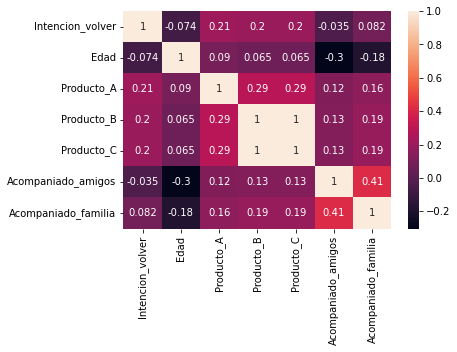

In [724]:
columnas_numericas = ['Intencion_volver','Edad','Producto_A','Producto_B','Producto_C', 
                      'Acompaniado_amigos','Acompaniado_familia']
data_numerico = pd.DataFrame(data, columns=columnas_numericas)

corrMatrix = data_numerico.corr()
sn.heatmap(corrMatrix, annot=True)

Vemos que hay correlación positiva perfecta entre el Producto_B y el Producto_C, por tanto podemos descartar una de estas variables para nuestros modelos, he decidido dejar fuera el Producto_C.

Por otro lado hay algo de correlación entre Acompaniado_amigos y Acompaniado_familia y un poco menos entre el Producto_A y Producto_B, posiblemente en nuestro modelo de regresión logística entre solo una variable de cada una de estas variables correladas.

## Análisis Univariable

Aquí iremos viendo como se comporta cada varible con respecto a la variable objetivo. 

Es posible hacer modelos para ver si las variables son significativas o no pero lo hare de forma simple con agrupaciones.

In [725]:
# Edad
# Para la edad creamos una agrupación
data['Edad_A'] = "00. NA" 
data.loc[data['Edad'] < 18, 'Edad_A'] = "01. < 18"
data.loc[data['Edad'] >= 18, 'Edad_A'] = "02. 18-30"
data.loc[data['Edad'] >= 30, 'Edad_A'] = "03. 30-40"
data.loc[data['Edad'] >= 40, 'Edad_A'] = "04. > 40"

data.groupby(['Edad_A']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                     count  mean
Edad_A                          
00. NA                 177  0.29
01. < 18               113  0.54
02. 18-30              271  0.35
03. 30-40              167  0.44
04. > 40               163  0.37

Vemos que la intención de volver varía en función de las edades y no es lineal, en los menores de edad es considerablemente superior que el resto.

Por otro lado llama la atención que los NA de edad tengan la intención de volver más baja que el resto, una posibilidad es que sean clientes menos preocupados en el parque y por eso rellenan la encuesta a medias y tienen peor intención de volver.

Esto último hay que tenerlo en cuenta a la hora de imputar la edad, en nuestro caso haremos una imputación por la media pero es importante añadir una variable indicadora de los clientes que no tienen la edad informada.

In [726]:
data.groupby(['Sexo']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                  count  mean
Sexo                         
female              314  0.74
male                577  0.19

Vemos que las mujeres tienen mucha más intención de volver que los hombres.

In [727]:
data.groupby(['Sexo', 'Edad_A']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                            count  mean
Sexo   Edad_A                          
female 00. NA                  53  0.68
       01. < 18                55  0.69
       02. 18-30               92  0.73
       03. 30-40               60  0.83
       04. > 40                54  0.78
male   00. NA                 124  0.13
       01. < 18                58  0.40
       02. 18-30              179  0.16
       03. 30-40              107  0.21
       04. > 40               109  0.17

Si vemos la intención de volver por sexo y edades, tenemos que en las mujeres la intención de volver va aumentando con la edad, y que los hombres cuando son menores de 18 tienen buena intención de volver pero cae drásticamente según se hacen mayores.

Esto nos indica que hay una interacción entre el sexo y la edad.

In [728]:
data.groupby(['Punto_Compra']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                        count  mean
Punto_Compra                       
C                         168  0.55
Q                          77  0.39
S                         644  0.34

In [729]:
data.groupby(['Segmento_cliente']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                            count  mean
Segmento_cliente                       
1                             216  0.63
2                             184  0.47
3                             491  0.24

In [730]:
data.groupby(['Acompaniado_amigos']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                              count  mean
Acompaniado_amigos                       
0                               608  0.35
1                               209  0.54
2                                28  0.46
3                                16  0.25
4                                18  0.17
5                                 5  0.00
8                                 7  0.00

In [731]:
data.groupby(['Acompaniado_familia']).agg({'Intencion_volver' : ['count', 'mean']}).round(2)

Intencion_volver      
                               count  mean
Acompaniado_familia                       
0                                678  0.34
1                                118  0.55
2                                 80  0.50
3                                  5  0.60
4                                  4  0.00
5                                  5  0.20
6                                  1  0.00

Tenemos que la intención de volver:
- Es mejor en el punto de compra C.
- Es mejor en el segmento 1, luego el 2 y en último lugar el 3.
- Es mejor en los clientes que van acompañados de amigos o familiares.
    

## Preparación de la BBDD

Aquí añadimos variables adicionales o transformamos las variables en función de lo que hemos visto anteriormente y preparamos la BBDD para que pueda ser utilizada para entrenar los modelos.

In [732]:
# Imputamos valores perdidos de edad con la media puesto que representan un 20% de los datos
# y nos quitaríamos mucha información si decidimos eliminarlos.
# Se podría imputar también haciendo otro modelo de edad, aunque
# por simplicidad mantendré la media
# Informo primero en otra variable las observaciones con NA
data['Edad_A'] = 0
data.loc[data['Edad'].isnull(),'Edad_A'] = 1
# Rellenos los NA con la media
data['Edad'] = data['Edad'].fillna(data['Edad'].mean())

# Creamos variables extras
# Sumas de Acompañantes y de Productos A y B
data['Acompaniado_total'] = data['Acompaniado_amigos'] + data['Acompaniado_familia']
data['Acompaniado'] = data['Acompaniado_total']
data.loc[data['Acompaniado_total'] > 1,'Acompaniado'] = 1
data['Producto_total'] = data['Producto_A'] + data['Producto_B']

# Porcentajes de productos respecto a la suma del Producto A y B                            
data['Producto_A_porcentaje'] = data['Producto_A'] / data['Producto_total']
data['Producto_B_porcentaje'] = data['Producto_B'] / data['Producto_total']
# Limpio los NaN generados por la gente que no gastado nada en Productos.
data['Producto_A_porcentaje'] = data['Producto_A_porcentaje'].fillna(0)
data['Producto_B_porcentaje'] = data['Producto_B_porcentaje'].fillna(0)

# Transformaciones a logaritmo (sumo 1 para evitar el -Inf en 0)
data['Producto_A_log'] = np.log(data['Producto_A'] + 1)
data['Producto_B_log'] = np.log(data['Producto_B'] + 1)
data['Producto_total_log'] = np.log(data['Producto_total'] + 1)

## Creación de train y test

In [733]:
# Nos quedamos primero con las variables que vamos a utilizar
data_mod = data.drop(['ClientId', 'Nombre','Producto_C'], axis = 1)

# Creamos las dummies
categorical = [col for col in data_mod.columns if data_mod[col].dtypes == 'O']
dummies_df = pd.get_dummies(data_mod, columns = categorical)
dummies_df = dummies_df.drop(['Sexo_male'], axis = 1) # Quitamos male ya que es redundante
dummies_df.head()

,Edad,Producto_A,Producto_B,Intencion_volver,Acompaniado_amigos,Acompaniado_familia,Edad_A,Acompaniado_total,Acompaniado,Producto_total,...,Producto_A_log,Producto_B_log,Producto_total_log,Sexo_female,Punto_Compra_C,Punto_Compra_Q,Punto_Compra_S,Segmento_cliente_1,Segmento_cliente_2,Segmento_cliente_3
0,22.0,0.824350,1.983631,0,1,0,0,1,1,2.807981,...,0.601224,1.093141,1.337099,0,0,0,1,0,0,1
1,38.0,44.359555,8.311497,1,1,0,0,1,1,52.671052,...,3.814621,2.231250,3.982874,1,1,0,0,1,0,0
2,26.0,4.828502,0.955905,1,0,0,0,0,0,5.784407,...,1.762760,0.670853,1.914627,1,0,0,1,0,0,1
3,35.0,33.101448,6.173654,1,1,0,0,1,1,39.275103,...,3.529340,1.970415,3.695733,1,0,0,1,1,0,0
4,35.0,6.930369,0.345636,0,0,0,0,0,0,7.276005,...,2.070700,0.296867,2.113360,0,0,0,1,0,0,1


In [734]:
# Separación de train y test
random.seed(1234)
drop_cols = ['Intencion_volver']
X = dummies_df.drop(drop_cols, axis = 1)
y = dummies_df['Intencion_volver']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Regresión logística

Lo primero que hacemos es elegir las variables que van a entrar en nuestro modelo, para ello he decidido usar un stepwise.

Una vez que tenemos las variables creamos nuestro modelo y obtenemos un resumen del modelo y algunas métricas del modelo.

In [735]:
def step_wise(X, y,threshold=0.05,verbose=False):
    initial_list = []
    included = list(initial_list)
    included_pval = []
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        #print(excluded)
        new_pval = pd.Series(index=excluded)
        #print(new_pval)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            try:
                new_pval[new_column] = model.pvalues[new_column]
            except:
                None
        best_pval = new_pval.min()
        if best_pval < threshold:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            included_pval.append(best_pval)
            changed=True
            #if verbose:
            print('Añade {:30} con p-value {:.6}'.format(best_feature, best_pval))
        result_list = [(included[i], included_pval[i]) for i in range(0, len(included))]
        if not changed:
            break

    return result_list, included

In [736]:
import warnings
warnings.filterwarnings('ignore')
pvalores, variables = step_wise(X_train, y_train)

Añade Sexo_female                    con p-value 4.30224e-50
Añade Segmento_cliente_3             con p-value 2.35843e-18
Añade Segmento_cliente_2             con p-value 2.32827e-05
Añade Segmento_cliente_1             con p-value 2.49047e-22
Añade Edad                           con p-value 4.45364e-05
Añade Acompaniado_amigos             con p-value 0.000442916
Añade Producto_total_log             con p-value 0.00642458
Añade Punto_Compra_S                 con p-value 0.0292461


In [737]:
# Me quedo con las variables incluidas en el stepwise
X_train = X_train.drop(columns=[col for col in X_train if col not in variables])
X_test = X_test.drop(columns=[col for col in X_test if col not in variables])

In [738]:
def reg_logistica(X_train,y_train,X_test,y_test):
    
    results = sm.Logit(y_train, X_train).fit()

    print(results.summary2())
    
    predictions = results.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    optimal_tpr_list, optimal_tpr, optimal_fpr_list, optimal_fpr, optimal_threshold = def_optimal_threshold(y_test, X_test, results, fpr, tpr, thresholds)
    
    threshold = optimal_threshold.iloc[0]
    
    print("Punto de corte optimo de la curva ROC:", threshold.round(3), "\n")

    pred = np.array(predictions > threshold, dtype=float)
    table = np.histogram2d(y_test, pred, bins=2)[0]
    print("Matriz de confusión sobre el test:")
    print(table, "\n")
    
    acc = accuracy(results.pred_table(threshold))
    print("Accuracy: ", round(acc, 3))
    # Sensibilidad
    print('Sensibilidad: ', round(optimal_tpr.iloc[0], 3))
    # Especificidad
    print('Especificidad: ', round(optimal_fpr.iloc[0],3))
   
    
    auc = curva_roc(X_test, y_test, results,optimal_fpr_list, optimal_tpr_list)
    print('AUC: ', round(auc, 3))
    
    # Find prediction to the dataframe applying threshold
    final_predictions = []
    
    predictions_series = pd.Series(predictions)
    
    final_predictions = predictions_series.map(lambda x: 1 if x > threshold else 0)
    
    return predictions, final_predictions, results, auc
 
    
def def_optimal_threshold(y, X, results, fpr, tpr, thresholds):
    ####################################
    # Optimal threshold : donde tpr es alta y fpr es baja
    # tpr - (1-fpr) es cero o cerca de cero --> optimal cut off point
    ####################################

    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    optimal_tpr_list = roc.iloc[:,1].tolist()
    optimal_fpr_list = roc.iloc[:,0].tolist()
        
    optimal = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    optimal_threshold = optimal['thresholds']
    optimal_tpr = optimal['tpr']
    optimal_fpr = optimal['1-fpr']
        
    return optimal_tpr_list, optimal_tpr, optimal_fpr_list, optimal_fpr, optimal_threshold
   
    
def curva_roc(X, y, results, fpr, tpr):
    auc = roc_auc_score(y, results.predict(X))
    
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate: Sensibilidad')
    plt.xlabel('False Positive Rate: 1-Especificidad')
    plt.show()
    return auc
    

def accuracy(pred_table):
    tp, fp, fn, tn = map(float, pred_table.flatten())
    acc = (tp + tn) / (tp + tn + fp + fn)
    return acc

Optimization terminated successfully.
         Current function value: 0.441073
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.341     
Dependent Variable:  Intencion_volver AIC:              644.0878  
Date:                2022-02-19 17:57 BIC:              680.6325  
No. Observations:    712              Log-Likelihood:   -314.04   
Df Model:            7                LL-Null:          -476.73   
Df Residuals:        704              LLR p-value:      2.2810e-66
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Edad               -0.0379   0.0088 -4.3105 0.0000 -0.0551 -0.0207
Acompaniado_amigos -0.4839   0.1306 -3.7064 0.0002 -0

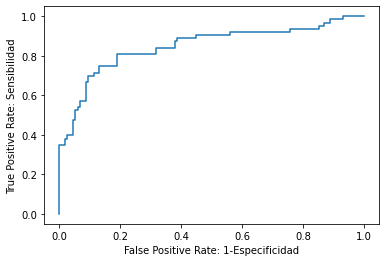

AUC:  0.848


In [739]:
predictions, predictions2, modelo, auc = reg_logistica(X_train, y_train, X_test, y_test)

## Random Forest

En el random forest tenemos que obtener los parámetros optimos a utilizar.

In [740]:
# Creamos un grid de posibles parámetros

random_grid = {'n_estimators': [100],
               'min_samples_leaf': [1,2,5,10,20,30,50,70,100],
               'bootstrap': [True, False]}

# Creamos un modelo de base
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'min_samples_leaf': [1, 2, 5, 10, 20,
                                                             30, 50, 70, 100],
                                        'n_estimators': [100]},
                   random_state=42, verbose=2)

In [741]:
rf_random.best_params_

{'n_estimators': 100, 'min_samples_leaf': 2, 'bootstrap': True}

In [742]:
model_rf = RandomForestClassifier(random_state=42, min_samples_leaf=2, n_estimators=100, bootstrap=True)
    
#entrenamiento modelo
model_rf.fit(X_train, y_train)
    
# predicciones y evaluación modelo 
predictions_rf = model_rf.predict(X_test)
matrix_rf = confusion_matrix(y_test,predictions_rf)
accuracy_rf = accuracy_score(y_test, predictions_rf)
    
print("Accuracy: ", round(accuracy_rf,3))
print(matrix_rf)

Accuracy:  0.844
[[104  12]
 [ 16  47]]


In [743]:
# Sacamos el AUC
predictions_rf_prob = model_rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, predictions_rf_prob)
print('Área bajo la curva:', round(auc,3))

Área bajo la curva: 0.878


Dependiendo de la semilla aleatoria pueden variar un poco los resultados pero en general la precisión del random forest es ligeramente mejor que la de regresión logística, lo mismo ocurre con el AUC.

Si buscamos maximizar la precisión entonces el random forest es mejor modelo que la regresión logística.
Por otro lado, puede que prefiramos usar regresión logística en caso de que queramos un modelo más sencillo de entender.

A partir de las predicciones dadas por el modelo, el equipo de marketing ya puede tomar una decisión sobre a que clientes aplicarles una campaña de marketing, basta con seleccionar el punto de corte adecuado para dicha campaña en función de los costes para conseguir el máximo EV.